<a href="https://colab.research.google.com/github/Raksantos/IADD-Notebooks/blob/main/IADD_Applying_CXNet_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-s69nansn
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-s69nansn


In [ ]:
!pip install pydicom
!pip install kornia

In [ ]:
import os
import fastai
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.data.all import *
from fastai.vision.models import *

from google.colab import drive
drive.mount('/content/gdrive')

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os, glob, numpy as np, shutil, matplotlib.pyplot as plt, cv2.cv2 as cv2, seaborn as sns
import tensorflow as tf, keras
import copy

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Flatten, BatchNormalization, Dropout
# from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Concatenate, Activation
from tensorflow.keras import Model, optimizers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample, class_weight

In [ ]:
#!unzip gdrive/My\ Drive/IADD-2020.2/jpg-v2.0.zip

In [ ]:
def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi

In [ ]:
def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf

In [ ]:
def BEASF(image, gamma):
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

In [ ]:
def data_preparation(path):
    atypical_images = list()

    i = 0

    for img_name in glob.glob(pathname=path + '/train/atypical/*.jpg'):
      img = load_img(path=img_name, color_mode='grayscale')
      img = img_to_array(img=img, data_format='channels_last')
      atypical_images.append(img)

      if(i > 100):
        break

      i += 1

    atypical_images = np.array(atypical_images)
    print('number of atypical chest xrays:', len(atypical_images))

    i = 0

    indeterminate_images = list()
    for img_name in glob.glob(pathname=path + '/train/indeterminate/*.jpg'):
      img = load_img(path=img_name, color_mode='grayscale')
      img = img_to_array(img=img, data_format='channels_last')
      indeterminate_images.append(img)
      if(i > 100):
        break

      i += 1

    indeterminate_images = np.array(indeterminate_images)
    print('number of indeterminate chest xrays:', len(indeterminate_images))

    i = 0

    typical_images = list()
    for img_name in glob.glob(pathname=path + '/train/typical/*.jpg'):
      img = load_img(path=img_name, color_mode='grayscale')
      img = img_to_array(img=img, data_format='channels_last')
      typical_images.append(img)
      if(i > 100):
        break

      i += 1

    typical_images = np.array(typical_images)
    print('number of typical chest xrays:', len(typical_images))

    i = 0

    negative_images = list()
    for img_name in glob.glob(pathname=path + '/train/negative/*.jpg'):
      img = load_img(path=img_name, color_mode='grayscale')
      img = img_to_array(img=img, data_format='channels_last')
      negative_images.append(img)
      if(i > 100):
        break

      i += 1

    negative_images = np.array(negative_images)
    print('number of negative chest xrays:', len(negative_images))

    atypical_labels = [1 for _ in range(len(atypical_images))]
    indeterminate_labels = [1 for _ in range(len(indeterminate_images))]
    typical_labels = [1 for _ in range(len(typical_images))]
    negative_labels = [0 for _ in range(len(negative_images))]

    X = np.concatenate((atypical_images, indeterminate_images, typical_images, negative_images))
    y = np.array(atypical_labels + indeterminate_labels + typical_labels + negative_labels)

    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)

    # apply image enhancements and concat with the original image
    X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
    X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
    X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
    X = np.concatenate((X, X_beasf, X_clahe), axis=-1)
    X = np.array([X[idx] / 255. for idx in range(len(X))])

    print('number of total dataset images:', len(X))
    print('number of total dataset labels:', len(y))
    print('dataset shape:', X.shape)
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

    return X_train, X_test, y_train, y_test

In [ ]:
def base_model(input_shape):
    a0 = Input(shape=input_shape, name='input_layer')
    a1 = Conv2D(filters=32, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv_layer1')(a0)
    a2 = Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', name='conv_layer2')(a1)
    a3 = Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', name='conv_layer3')(a2)
    a4 = Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', name='conv_layer4')(a3)
    a5 = Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', name='conv_layer5')(a4)
    a6 = Flatten(name='flatten_layer')(a5)
    a7 = Dense(units=10, activation='relu', name='fc_layer1')(a6)
    a8 = Dense(units=10, activation='relu', name='fc_layer2')(a7)
    a9 = Dense(units=1, activation='sigmoid', name='output_layer')(a8)
    return Model(inputs=a0, outputs=a9, name='binary_classifier')

In [ ]:
def get_last_weights(folder):
    """
    find last saved weights file and its epoch number
    :param folder: string
    :return: int, string
    """
    num_epochs = list()
    for weights_file in glob.glob(folder + '/**.hdf5'):
        num_epoch = int(weights_file[weights_file.find('=')+1:weights_file.rfind('_')])
        num_epochs.append((num_epoch, weights_file))

    last_epoch = max(num_epochs)[0]
    print('last saved epoch:', last_epoch)
    last_file = max(num_epochs)[1]
    print('last saved file:', last_file)
    return last_epoch, last_file

In [ ]:
def delete_other_weights(folder, last_file):
    """
    delete all weights files saved before, except the last one which is the best
    :param folder: string
    :param last_file: string
    :return None
    """

    for weights_file in os.listdir(folder):
        if weights_file.endswith('.hdf5'):
            file_path = os.path.join(folder, weights_file)
            if file_path != last_file:
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print('failed to delete %s. because of: %s' % (file_path, e))
            else:
                pass
    print('deleted all weights files saved before, except the last one.')

number of atypical chest xrays: 102
number of indeterminate chest xrays: 102
number of typical chest xrays: 102
number of negative chest xrays: 102
number of total dataset images: 408
number of total dataset labels: 408
dataset shape: (408, 320, 320, 3)


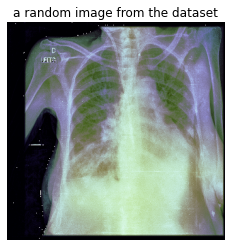

In [ ]:
path = "/content/gdrive/MyDrive/IADD-2020.2/jpg v2.0 - o ultimo gas"
X_train, X_test, y_train, y_test = data_preparation(path=path)

In [ ]:
augmenter = ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True, rescale=None)

In [ ]:
checkpoint = ModelCheckpoint(filepath='./checkpoints/base_model/v_free/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto', verbose=1, min_delta=0.002)

In [ ]:
cb_list = [checkpoint, early_stopping]

In [ ]:
classifier = base_model(input_shape=X_train[0].shape)
classifier.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
print(classifier.summary())
print('number of network layers:', len(classifier.layers))

Model: "binary_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 320, 320, 3)]     0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 158, 158, 32)      2432      
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 78, 78, 32)        9248      
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 38, 38, 32)        9248      
_________________________________________________________________
conv_layer4 (Conv2D)         (None, 18, 18, 32)        9248      
_________________________________________________________________
conv_layer5 (Conv2D)         (None, 8, 8, 32)          9248      
_________________________________________________________________
flatten_layer (Flatten)      (None, 2048)        

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

#add the following line because of this:
#https://stackoverflow.com/questions/61261907/on-colab-class-weight-is-causing-a-valueerror-the-truth-value-of-an-array-wit

class_weights = {i : class_weights[i] for i in range(2)} 

print('class weights are:', class_weights)
training = classifier.fit(augmenter.flow(x=X_train, y=y_train, batch_size=32), callbacks=cb_list, epochs=150,
      verbose=1, validation_data=(X_test, y_test), class_weight=class_weights)

class weights are: {0: 1.9404761904761905, 1: 0.6735537190082644}
Epoch 1/150
11/11 [==============================] - 7s 570ms/step - loss: 0.6935 - accuracy: 0.6043 - val_loss: 0.6942 - val_accuracy: 0.2195

Epoch 00001: val_loss improved from inf to 0.69419, saving model to ./checkpoints/base_model/v_free/eps=001_valLoss=0.6942.hdf5
Epoch 2/150
11/11 [==============================] - 6s 543ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6924 - val_accuracy: 0.7805

Epoch 00002: val_loss improved from 0.69419 to 0.69238, saving model to ./checkpoints/base_model/v_free/eps=002_valLoss=0.6924.hdf5
Epoch 3/150
11/11 [==============================] - 6s 590ms/step - loss: 0.6931 - accuracy: 0.7423 - val_loss: 0.6920 - val_accuracy: 0.7805

Epoch 00003: val_loss improved from 0.69238 to 0.69196, saving model to ./checkpoints/base_model/v_free/eps=003_valLoss=0.6920.hdf5
Epoch 4/150
11/11 [==============================] - 6s 539ms/step - loss: 0.6931 - accuracy: 0.7423 - val_los

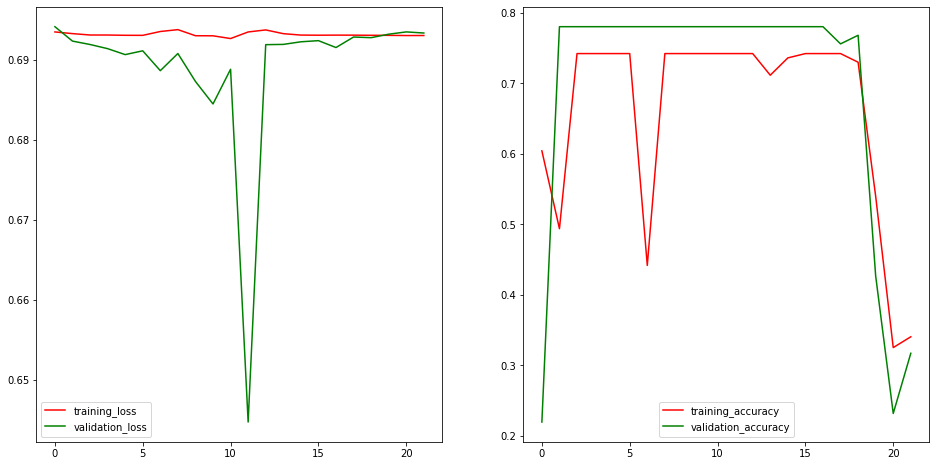

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], color='r', label='training_accuracy')
plt.plot(training.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()
fig.savefig('./checkpoints/base_model/v_free/training_history.png')

In [ ]:
"""best results on the test-set"""
weights_folder = './checkpoints/base_model/v_free'
_, best_weights = get_last_weights(weights_folder)
acc = float(best_weights[best_weights.rfind('=')+1:best_weights.rfind('.')])
print('best validation accuracy:', acc)
classifier.load_weights(best_weights)
delete_other_weights(folder=weights_folder, last_file=best_weights)


last saved epoch: 12
last saved file: ./checkpoints/base_model/v_free/eps=012_valLoss=0.6447.hdf5
best validation accuracy: 0.6447
deleted all weights files saved before, except the last one.


In [ ]:
"""classification reports"""
y_pred = classifier.predict(X_test)
print('number of test-set images:', len(y_test))
print(y_test)
y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
print(y_pred)
y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_rnd)
print('confusion matrix:')
print(cm)
print('test-set accuracy:', (cm[0][0] + cm[1][1])/np.sum(cm))

print('classification report:')
print(classification_report(y_true=y_test, y_pred=y_pred_rnd,
                            target_names=['normal', 'covid']))

number of test-set images: 82
[1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 0 1 0 1]
[0.53 0.53 0.53 0.53 0.54 0.54 0.54 0.6  0.54 0.53 0.55 0.54 0.54 0.53
 0.54 0.53 0.54 0.53 0.54 0.54 0.55 0.54 0.53 0.55 0.54 0.55 0.53 0.53
 0.54 0.55 0.55 0.53 0.54 0.54 0.54 0.54 0.54 0.55 0.54 0.56 0.59 0.53
 0.54 0.55 0.54 0.54 0.54 0.53 0.55 0.52 0.54 0.52 0.53 0.54 0.55 0.54
 0.62 0.55 0.54 0.54 0.53 0.55 0.54 0.53 0.54 0.53 0.54 0.54 0.53 0.53
 0.54 0.55 0.54 0.53 0.53 0.54 0.54 0.61 0.53 0.57 0.53 0.54]
confusion matrix:
[[ 0 18]
 [ 0 64]]
test-set accuracy: 0.7804878048780488
classification report:
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        18
       covid       0.78      1.00      0.88        64

    accuracy                           0.78        82
   macro avg       0.39      0.50      0.44        82
weighted avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


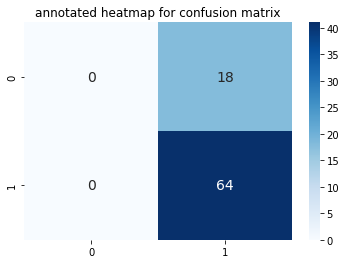

In [ ]:
fig1 = plt.figure()
sns.heatmap(data=cm, cmap='Blues', annot=True, annot_kws={'size': 14}, fmt='d',
            vmin=0, vmax=len(y_test)/2.)
plt.title('annotated heatmap for confusion matrix')
plt.show()
fig1.savefig('./checkpoints/base_model/v_free/cm_heatmap.png')

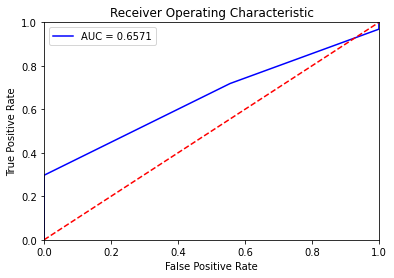

In [ ]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_pred, pos_label=None)
roc_auc = auc(x=fpr, y=tpr)
fig2 = plt.figure()
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig2.savefig('./checkpoints/base_model/v_free/roc.png')

In [ ]:
"""save the model to a json file"""
model_json = classifier.to_json()
with open("./checkpoints/base_model/v_free/base_model.json", "w") as json_file:
    json_file.write(model_json)